In [1]:
import dspy
import json

In [ ]:
#vllm serve Qwen/Qwen3-30B-A3B-Instruct-2507 --api-key testkey

In [3]:
fpath = "Antananarivo_001_0003.json" #"New York_010.json"
with open(fpath) as f:
  data = f.read()

data_json = json.loads(data)

persons = []
for i, person in enumerate(data_json['frames'][0]['detections']):
  persons.append((i, person['direction'], round(person['3D_60FOV'][0],5), round(person['3D_60FOV'][1],5), round(person['3D_60FOV'][2],5), person['bbox']))

detections = []
for person in persons:
  # detections.append({'person_id':person[0], 'direction':person[1], 'x':person[2], 'y':person[3], 'z':person[4]})
  detections.append({'person_id':person[0], 'x':person[2], 'y':person[3], 'z':person[4]})

In [4]:
len(data_json['frames'])

50

In [5]:
lm = dspy.LM('openai/Qwen/Qwen3-30B-A3B-Instruct-2507', api_key='testkey', api_base='http://localhost:8000/v1', temperature=0.6, max_tokens=32768)
dspy.configure(lm=lm)

In [20]:
class IdentifyGroups(dspy.Signature):
    """"Identify sets of people that are very close to each other from the given 3D coordinates. Use all three coordinates in distance calculation. Select an appropriate grouping threshold based on all pairwise distances. Do not hallucinate empty sets."""

    detections: list[dict] = dspy.InputField(desc="list of dictionary objects with the keys: person_id, x, y, z.")
    groups: list[list[int]] = dspy.OutputField(desc="A list of lists of person_ids that are close to each other.")


lm_detect_crowds = dspy.ChainOfThought(IdentifyGroups)

In [21]:
pred = lm_detect_crowds(detections=detections)

{'prompt': None,
 'messages': [{'role': 'system',
   'content': 'Your input fields are:\n1. `detections` (list[dict]): list of dictionary objects with the keys: person_id, x, y, z.\nYour output fields are:\n1. `reasoning` (str): \n2. `groups` (list[list[int]]): A list of lists of person_ids that are close to each other.\nAll interactions will be structured in the following way, with the appropriate values filled in.\n\n[[ ## detections ## ]]\n{detections}\n\n[[ ## reasoning ## ]]\n{reasoning}\n\n[[ ## groups ## ]]\n{groups}        # note: the value you produce must adhere to the JSON schema: {"type": "array", "items": {"type": "array", "items": {"type": "integer"}}}\n\n[[ ## completed ## ]]\nIn adhering to this structure, your objective is: \n        "Identify sets of people that are very close to each other from the given 3D coordinates. Use all three coordinates in distance calculation. Select an appropriate grouping threshold based on all pairwise distances. Do not hallucinate empty

In [77]:
detections

[{'person_id': 0, 'x': -1.23846, 'y': -0.08668, 'z': 1.37407},
 {'person_id': 1, 'x': -2.66259, 'y': -1.84964, 'z': 6.97575},
 {'person_id': 2, 'x': -0.88928, 'y': -1.6486, 'z': 6.39811},
 {'person_id': 3, 'x': -2.02317, 'y': -2.69756, 'z': 9.41435},
 {'person_id': 4, 'x': -7.39544, 'y': -2.41633, 'z': 9.7836},
 {'person_id': 5, 'x': -1.62978, 'y': -2.41244, 'z': 8.61212},
 {'person_id': 6, 'x': -3.21851, 'y': -1.55828, 'z': 6.81062},
 {'person_id': 7, 'x': -5.80663, 'y': -1.61538, 'z': 6.80575},
 {'person_id': 8, 'x': -5.87386, 'y': -2.26144, 'z': 9.15644},
 {'person_id': 9, 'x': -5.83694, 'y': -2.51407, 'z': 9.11408}]

In [78]:
pred.groups

[[1, 6], [3, 5], [8, 9]]

In [79]:
import cv2
import copy
import matplotlib.pyplot as plt

In [80]:
video_path = "chunk_001.mp4" #"chunk_010.mp4"  # Replace with the actual path to your MP4 file
cap = cv2.VideoCapture(video_path)

frames = []
while True:
  ret, frame = cap.read()  # Read a frame

  if not ret:  # If no more frames, break the loop
    break

  frames.append(frame)

In [2]:
import os

In [7]:
'/lustre/nvwulf/scratch/pchitale/workspace/llm-crowd-detection/data/videos_frames/Dublin_Ireland_0003752_clip_002/00001.jpeg'.split('/')[-2]

'Dublin_Ireland_0003752_clip_002'

In [81]:
img = frames[1200]

In [82]:
CV2_COLORS = [
    (0, 0, 255),    # Red
    (0, 255, 0),    # Green
    (255, 0, 0),    # Blue
    (0, 255, 255),  # Yellow
    (255, 255, 0),  # Cyan
    (255, 0, 255),  # Magenta
    (0, 0, 0),      # Black
    (255, 255, 255) # White
]

img_gt = copy.deepcopy(img)
img2 = copy.deepcopy(img)

for i, group in enumerate(pred.groups):
  for person_id in group:
    person = persons[int(person_id)]
    xl, yl, x2, y2 = person[5]
    cv2.rectangle(img2, (xl,yl), (x2,y2), CV2_COLORS[i], 2)

for p in persons:
  x1, y1, x2, y2 = p[5]
  cv2.rectangle(img_gt, (x1,y1), (x2,y2), (0, 255, 0), 2)

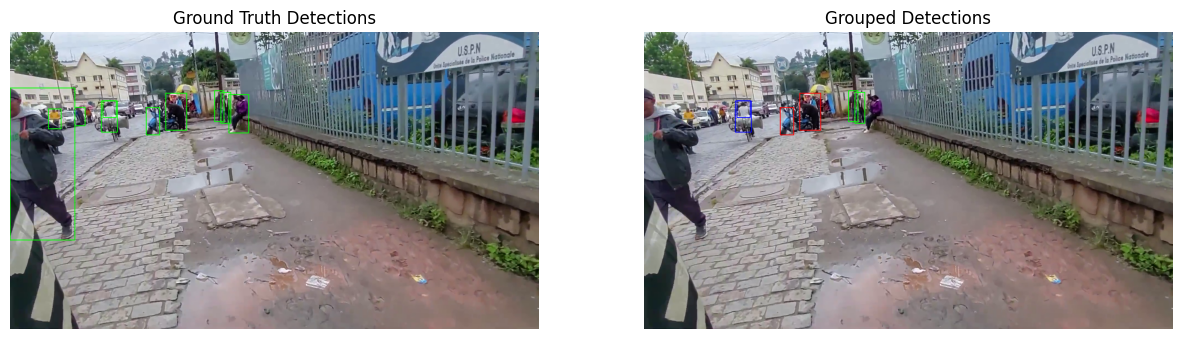

In [83]:
# plot img2 and img_gt side by side

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

axs[0].imshow(cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB))
axs[0].set_title('Ground Truth Detections')
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axs[1].set_title('Grouped Detections')
axs[1].axis('off')
plt.show()